# Computer Assignment #7

## Semi-Supervised Learning and LLMs

- **Ali Hamzehpour 810100129**
- **Mina Shirazi 810100250**
- **Mohammad Amin Yousefi 810100236**

### Summary

We are given the imdb reviews dataset but only a small portion of the data is labeled(Positive or Negative). We have to use semi-supervised methods to extend the labels to the rest of the data and then train a classifier based on these extended labeled data. We should also use LLMs as another method to extend our labelings and finally compare the results.

## 1. EDA
First we explore the data and see what we are dealing with.


We are given 3 files:
- `train_imdb.jsonl`: The labeled data
- `test_imdb.jsonl`: The test data(Also labeled)
- `aug_imdb_unlabeled.jsonl`: The unlabeled data that we should extend the labels for.

We load all of them:

In [13]:
import pandas as pd

aug_imdb_unlabeled_path = 'imdb/aug_imdb_unlabeled.jsonl'
test_imdb_path = 'imdb/test_imdb.jsonl'
train_imdb_path = 'imdb/train_imdb.jsonl'


train_data = pd.read_json(train_imdb_path, lines=True)
test_data = pd.read_json(test_imdb_path, lines=True)
aug_data = pd.read_json(aug_imdb_unlabeled_path, lines=True)

As you can see, apart from the text, we are also given the embedding of the text which is a 768-dimensional feature vector. We will use this feature vector to train our models.

In [14]:
train_data.head()

,text,label,embedding
0,fairly good romantic comedy in which i don't t...,1,"[-0.0167805497, -0.0395836979, 0.1233159453000..."
1,"""dressed to kill"", is one of the best thriller...",1,"[-0.12526972590000002, 0.10147688540000001, 0...."
2,i'm glad that users (as of this date) who like...,1,"[0.1312361956, 0.0294876788, 0.2328549027, -0...."
3,needed an excuse to get out of the house while...,0,"[0.1387384981, 0.0460377187, 0.3447172046, -0...."
4,john candy's performance in once upon a crime ...,1,"[0.1606466323, -0.1768193543, 0.35633808370000..."


In [15]:
test_data.head()

,text,label,embedding
0,the 60s (1999) d: mark piznarski. josh hamilto...,0,"[-0.2179879397, -0.1741176099, 0.0884851664000..."
1,hello. this movie is.......well.......okay. ju...,1,"[-0.07834710930000001, -0.279764235, 0.6189775..."
2,eyeliner was worn nearly 6000 years ago in egy...,1,"[0.03139963, -0.1652034372, 0.1265712678, -0.0..."
3,"this has to be, by far, the absolute worst mov...",0,"[-0.0552324504, -0.1593759954, 0.0467776954, -..."
4,"i like silent films, but this was a little too...",0,"[0.0934860557, 0.026243483600000003, 0.0843501..."


In [16]:
aug_data.head()

,text,embedding
0,there is no relation at all between fortier an...,"[-0.09757755700000001, -0.1536363065, 0.311417..."
1,in the process of trying to establish the audi...,"[-0.00033669360000000004, 0.08777780830000001,..."
2,i give this movie 7 out of 10 because the vill...,"[-0.275570631, -0.32913637160000003, 0.0793179..."
3,this is the best sci-fi that i have seen in my...,"[0.1461943835, -0.2785910368, 0.4456491172, -0..."
4,what an appalling piece of rubbish!!! who are ...,"[0.1696606129, 0.354041934, 0.4451519549000000..."


Also we can see that we have 150 rows for both train and test data and 1014 rows for the unlabeled data.

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       150 non-null    object
 1   label      150 non-null    int64 
 2   embedding  150 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.6+ KB


In [18]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       150 non-null    object
 1   label      150 non-null    int64 
 2   embedding  150 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.6+ KB


In [19]:
aug_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1014 non-null   object
 1   embedding  1014 non-null   object
dtypes: object(2)
memory usage: 16.0+ KB


We also make sure that our data is balanced and we have no missing values.

In [20]:
train_data['label'].value_counts(normalize=True)

label
1    0.553333
0    0.446667
Name: proportion, dtype: float64

In [21]:
train_data.isnull().sum()

text         0
label        0
embedding    0
dtype: int64

### Preprocessing

We need to do some preprocessing before we explore our data.

First we define our stopwords. stopwords are the words that are very common and do not carry much information. We will remove them from our text. we usee `nltk` library to get the stopwords but we remove `not`, `no` and `nor` from the stopwords because they may carry some information in our case.

In [22]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

print(sorted(stop_words))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some',

In [23]:
stop_words.remove('nor')
stop_words.remove('not')
stop_words.remove('no')

Now we preprocess our text data. We take these steps:

- Remove the html tags
- Remove the urls
- Remove the tags
- Lowercase the text
- Fix the spellings(Using `TextBlob` library)
- Remove punctuation
- convert short negative forms to their original form(nt -> not)
- Tokenize the text
- Remove the stopwords
- Lemmatize the text(Which removes the inflections and returns the base or dictionary form of a word, which is known as the lemma)

In [24]:
import re
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import download
from textblob import TextBlob


download('punkt')
download('stopwords')
download('wordnet')

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # remove url
    text = re.sub(r'http\S+', '', text)
    # remove hashtag
    text = re.sub(r'#', '', text)
    # Convert to lowercase
    text = text.lower()
    # correct spelling
    text = TextBlob(text).correct().string
    #convert n't to not
    text = re.sub(r"n't", " not", text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # convert all short form of verb + nt to not
    #text = re.sub(r"wont|cant|dont|shouldnt|couldnt|wouldnt|isnt|arent|wasnt|werent|hasnt|havent|hadnt|doesnt|didnt|wont|cant|dont|shouldnt|couldnt|wouldnt|isnt|arent|wasnt|werent|hasnt|havent|hadnt|doesnt|didnt", "not", text)
    # Tokenize
    words = word_tokenize(text)
    #apply stemming
    #words = [stemmer.stem(word) for word in words if word not in stop_words]
    #apply lemmatization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return words

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\minas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\minas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\minas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
train_data['tokenized'] = train_data['text'].apply(preprocess_text)
train_data['processed_text'] = train_data['tokenized'].apply(lambda x: ' '.join(x))

train_data[['text', 'processed_text', 'tokenized', 'label']].head()

,text,processed_text,tokenized,label
0,fairly good romantic comedy in which i don't t...,fairly good romantic comedy not think ive ever...,"[fairly, good, romantic, comedy, not, think, i...",1
1,"""dressed to kill"", is one of the best thriller...",dressed kill one best tiller ever made dealing...,"[dressed, kill, one, best, tiller, ever, made,...",1
2,i'm glad that users (as of this date) who like...,im glad user date liked movie coming forward n...,"[im, glad, user, date, liked, movie, coming, f...",1
3,needed an excuse to get out of the house while...,needed excuse get house paint dried left movie...,"[needed, excuse, get, house, paint, dried, lef...",0
4,john candy's performance in once upon a crime ...,john candy performance upon crime possibly bes...,"[john, candy, performance, upon, crime, possib...",1


### Visualization

The most simple visualization we can do is to see the frequency of positive and negative labels in our data. We can see that the data is balanced but positive labels are a bit more than the negative labels.(This can affect the performance of the semi-supervised methods)

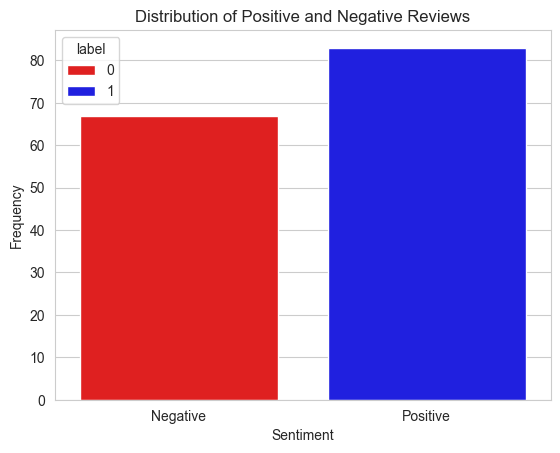

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

sns.countplot(x='label', data=train_data, hue='label', palette=['red', 'blue'])
plt.title('Distribution of Positive and Negative Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], rotation=0)
plt.show()

We use wordclouds to see the most frequent words in the positive and negative reviews. The word clouds provide a quick visual insight into what aspects of movies are most discussed in both positive and negative reviews. Positive reviews emphasize enjoyment and quality, while negative reviews focus on disappointment and criticism.

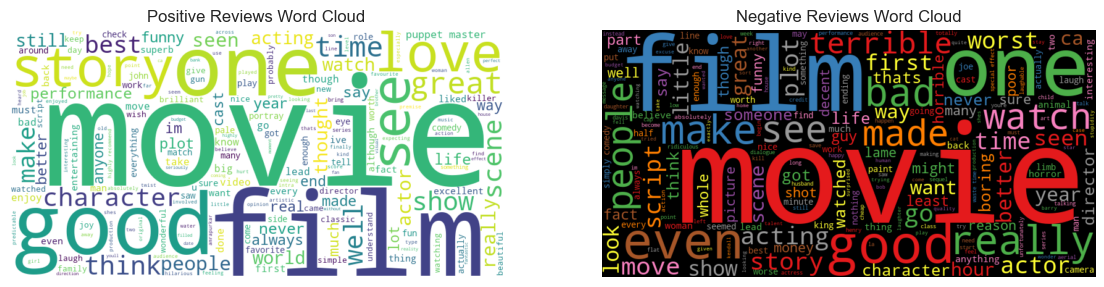

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_reviews = train_data[train_data['label'] == 1]['processed_text']
negative_reviews = train_data[train_data['label'] == 0]['processed_text']

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_reviews))
wordcloud_negative = WordCloud(width=800, height=400, background_color='black', colormap='Set1').generate(' '.join(negative_reviews))

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.title('Positive Reviews Word Cloud')
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Negative Reviews Word Cloud')
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')

plt.show()

Generate word clouds for the unique positive and negative words

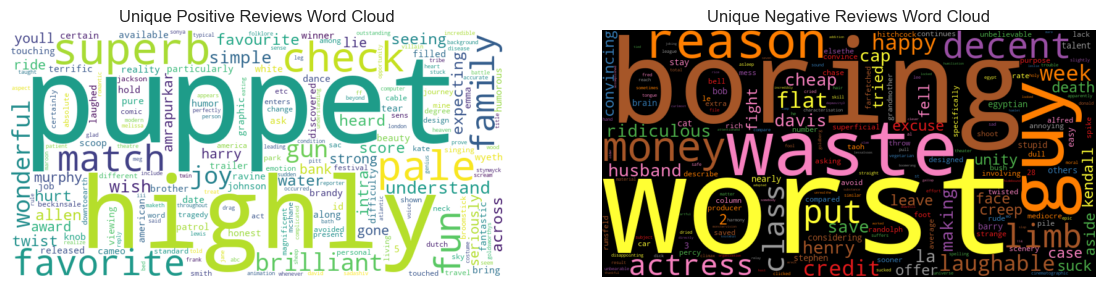

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

positive_words = set(positive_text.split())
negative_words = set(negative_text.split())

unique_positive_words = positive_words - negative_words

unique_negative_words = negative_words - positive_words

positive_word_counts = Counter(positive_text.split())
negative_word_counts = Counter(negative_text.split())

unique_positive_word_counts = {word: positive_word_counts[word] for word in unique_positive_words}
unique_negative_word_counts = {word: negative_word_counts[word] for word in unique_negative_words}

wordcloud_unique_positive = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(unique_positive_word_counts)
wordcloud_unique_negative = WordCloud(width=800, height=400, background_color='black', colormap='Set1').generate_from_frequencies(unique_negative_word_counts)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.title('Unique Positive Reviews Word Cloud')
plt.imshow(wordcloud_unique_positive, interpolation='bilinear')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Unique Negative Reviews Word Cloud')
plt.imshow(wordcloud_unique_negative, interpolation='bilinear')
plt.axis('off')

plt.show()


We also check the distribution of number of tokens in the reviews. We can see that the distribution is like a bimodal distribution with two peaks.

In [17]:
train_data['num_tokens'] = train_data['text'].apply(len)

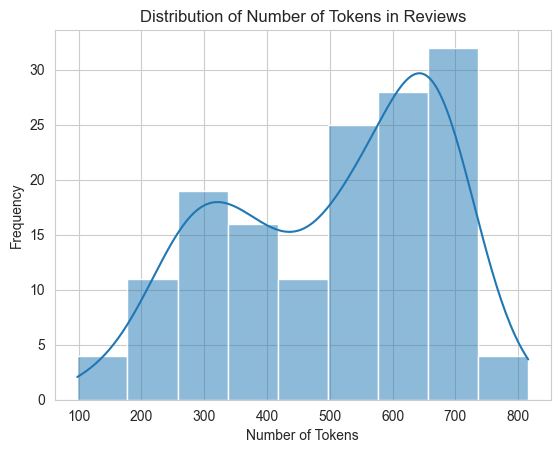

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

sns.histplot(train_data['num_tokens'], bins='sturges', kde=True)
plt.title('Distribution of Number of Tokens in Reviews')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

We check the same feature's distribution but this time we seperate the positive and negative reviews. We can see that negative reviews have more tokens than positive reviews and the reason for the second peak in the previous plot is mostly because of the negative reviews. The shape of the distributions are similar to some extent.(The negative reviews have higher peak in the second peak)

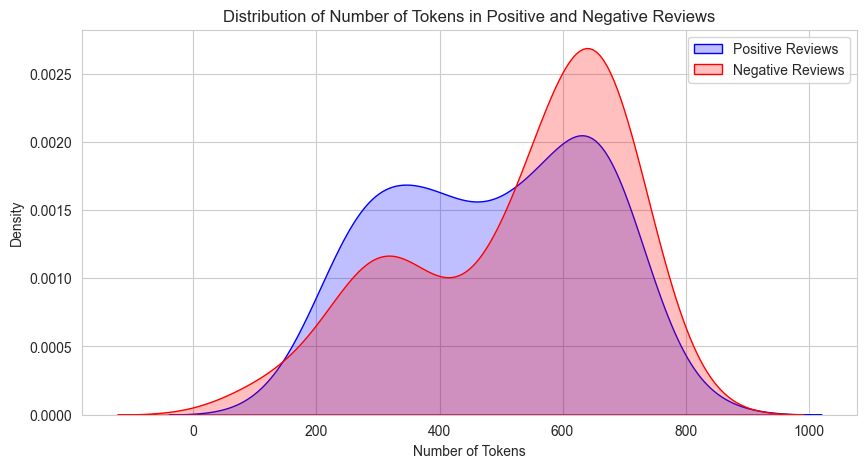

In [19]:
negative_reviews = train_data[train_data['label'] == 0]
positive_reviews = train_data[train_data['label'] == 1]

plt.figure(figsize=(10, 5))
sns.kdeplot(positive_reviews['num_tokens'], color='blue', fill=True, label='Positive Reviews')
sns.kdeplot(negative_reviews['num_tokens'], color='red', fill=True, label='Negative Reviews')
plt.title('Distribution of Number of Tokens in Positive and Negative Reviews')
plt.xlabel('Number of Tokens')
plt.ylabel('Density')
plt.legend(['Positive Reviews', 'Negative Reviews'])
plt.show()


We also visualize the boxplot for the number of tokens and again we can see that the negative reviews have more tokens than the positive reviews.

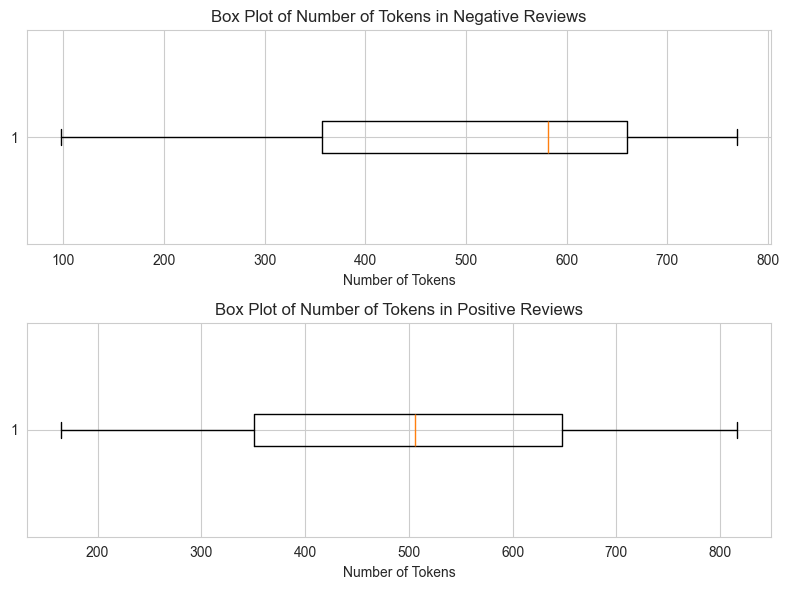

In [20]:
negative_reviews = train_data[train_data['label'] == 0]
positive_reviews = train_data[train_data['label'] == 1]

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

axs[0].boxplot(negative_reviews['num_tokens'], vert=False)
axs[0].set_title('Box Plot of Number of Tokens in Negative Reviews')
axs[0].set_xlabel('Number of Tokens')

axs[1].boxplot(positive_reviews['num_tokens'], vert=False)
axs[1].set_title('Box Plot of Number of Tokens in Positive Reviews')
axs[1].set_xlabel('Number of Tokens')

plt.tight_layout()
plt.show()

wordclouds might be attractive but they are not very informative so we also used barplots to show the most frequent words.

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

def plot_most_common_words(reviews, title, ax):
    all_words = [word for tokens in reviews['tokenized'] for word in tokens]
    word_freq = Counter(all_words)
    most_common_words = word_freq.most_common(10)
    most_common_words_df = pd.DataFrame(most_common_words, columns=['word', 'frequency'])
    sns.barplot(y='word', x='frequency', data=most_common_words_df, hue='word', palette='pastel', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Word')

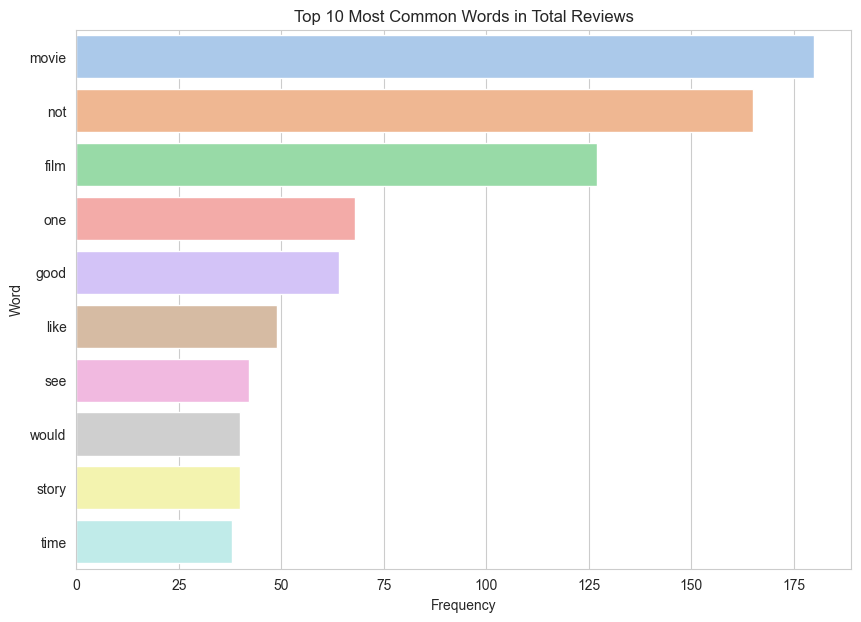

In [24]:
fig, ax = plt.subplots(figsize=(10, 7))

plot_most_common_words(train_data, 'Top 10 Most Common Words in Total Reviews', ax)

We also did the same again but this time we seperated the positive and negative reviews. We can see that the most frequent words are different in positive and negative reviews. For example `Not` is the most frequent word in negative reviews but it is in the 3rd place in positive reviews or positive words like `good` has higher frequency in positive reviews than negative reviews.

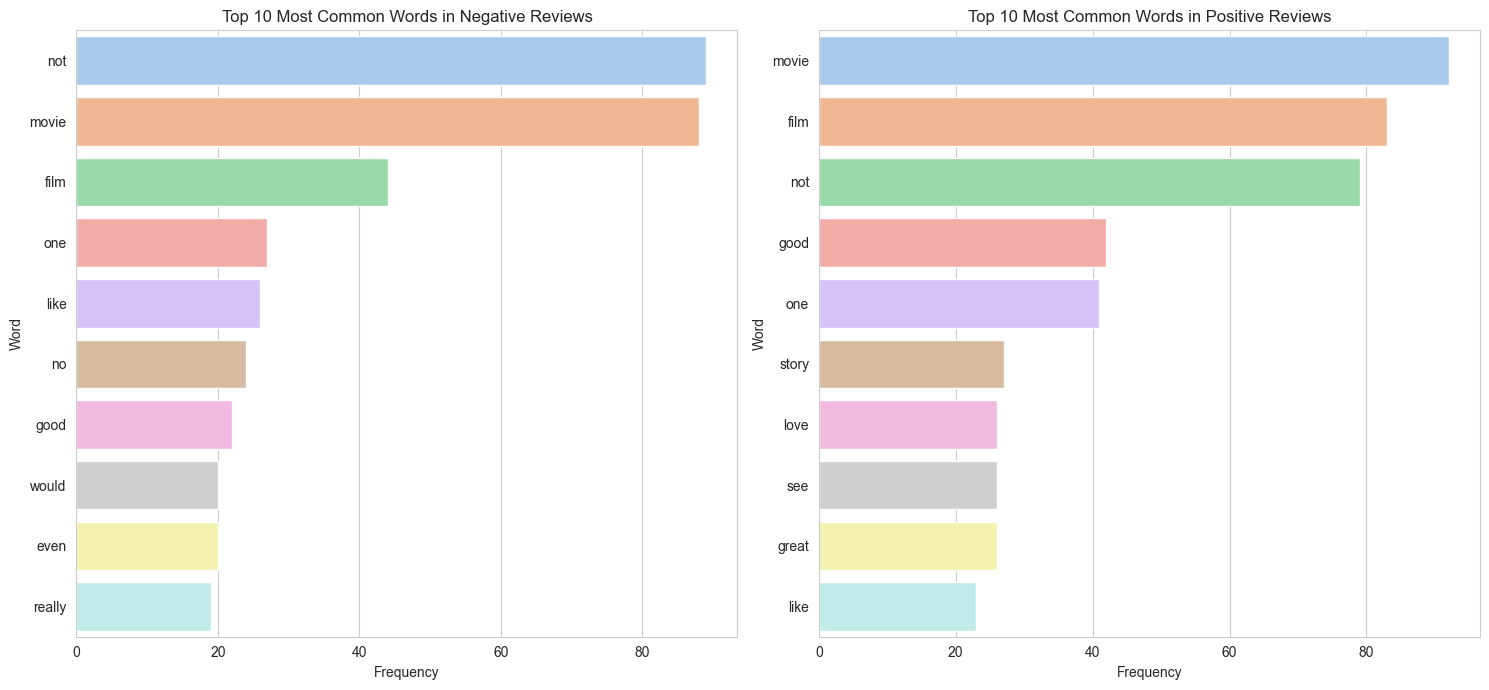

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

plot_most_common_words(positive_reviews, 'Top 10 Most Common Words in Positive Reviews', axes[1])

plot_most_common_words(negative_reviews, 'Top 10 Most Common Words in Negative Reviews', axes[0])

plt.tight_layout()
plt.show()

We also found the most frequent double words that came after each other in the reviews.(These are called 2-grams)

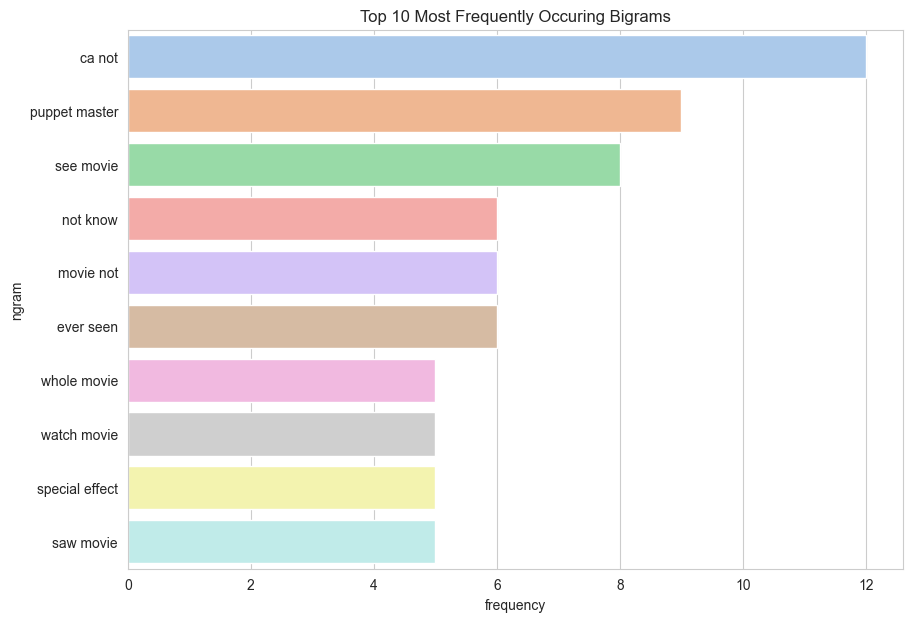

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

plt.figure(figsize=(10, 7))
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(train_data['processed_text'])

count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10], hue=ngram_freq['ngram'][:10], palette='pastel', legend=False)
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

We did the same for the data from all the reviews (including the unlabeled data).

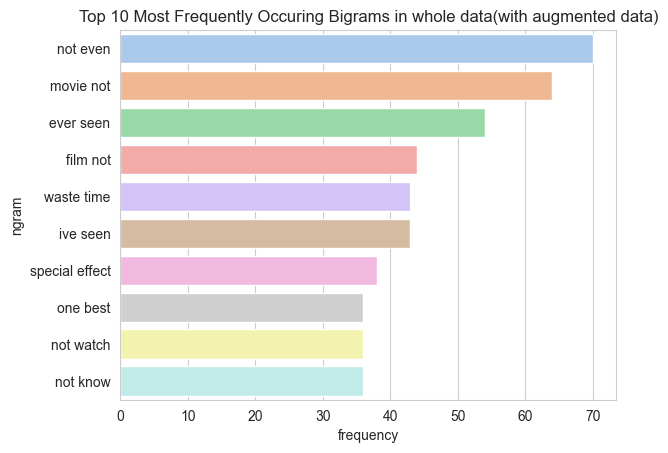

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(all_text_data['processed_text'])

count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10], hue=ngram_freq['ngram'][:10], palette='pastel', legend=False)
plt.title('Top 10 Most Frequently Occuring Bigrams in whole data(with augmented data)')
plt.show()

We noticed that `puppet master` was in the most frequent 2-grams so we check the reviews that contain this 2-gram and we can see in only one reviews this 2-gram is used many times!

In [26]:
has_puppet_master = train_data['processed_text'].apply(lambda x: 'puppet master' in x)

train_data[has_puppet_master]['text'].iloc[0]

'this movie is a great way for the series to finally end. peter (the boy from puppet master iii) is all grown up and is now the puppet master. well, this girl comes to destroy the puppets and learn toulon\'s secrets but instead she listens to the story about the puppets. most of this movie is footage from puppet master ii, puppet master iii, puppet master 4, puppet master 5, curse of the puppet master, and retro puppet master (sorry... but i guess paramount wouldn\'t let them use scenes from 1). personally i wish puppet master vs. demonic toys would finally be made but the way this movie ends they basically say "this is the final movie in the series..."'

In [33]:
aug_data

,text,embedding
0,there is no relation at all between fortier an...,"[-0.09757755700000001, -0.1536363065, 0.311417..."
1,in the process of trying to establish the audi...,"[-0.00033669360000000004, 0.08777780830000001,..."
2,i give this movie 7 out of 10 because the vill...,"[-0.275570631, -0.32913637160000003, 0.0793179..."
3,this is the best sci-fi that i have seen in my...,"[0.1461943835, -0.2785910368, 0.4456491172, -0..."
4,what an appalling piece of rubbish!!! who are ...,"[0.1696606129, 0.354041934, 0.4451519549000000..."
...,...,...
1009,unbelievable!<br /><br />this film gets a 7 ou...,"[-0.0955021083, 0.0211753864, 0.35705754160000..."
1010,sweet romantic drama/comedy about stewart and ...,"[0.017505046, -0.050160985400000004, 0.4082049..."
1011,"personally, i disdain the jerry springer show,...","[-0.19647170600000002, -0.0579777397, 0.179255..."
1012,this film looked promising but it was actually...,"[-0.0007334474000000001, -0.1367768645, 0.1660..."


We also performed EDA on embeddings and used feature reduction methods and visualized it in 2d.

In [44]:
df_embeddings = pd.DataFrame(train_data['embedding'].tolist())


In [46]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=50)
reduced_embeddings_pca = pca.fit_transform(df_embeddings)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
reduced_embeddings_tsne = tsne.fit_transform(reduced_embeddings_pca)


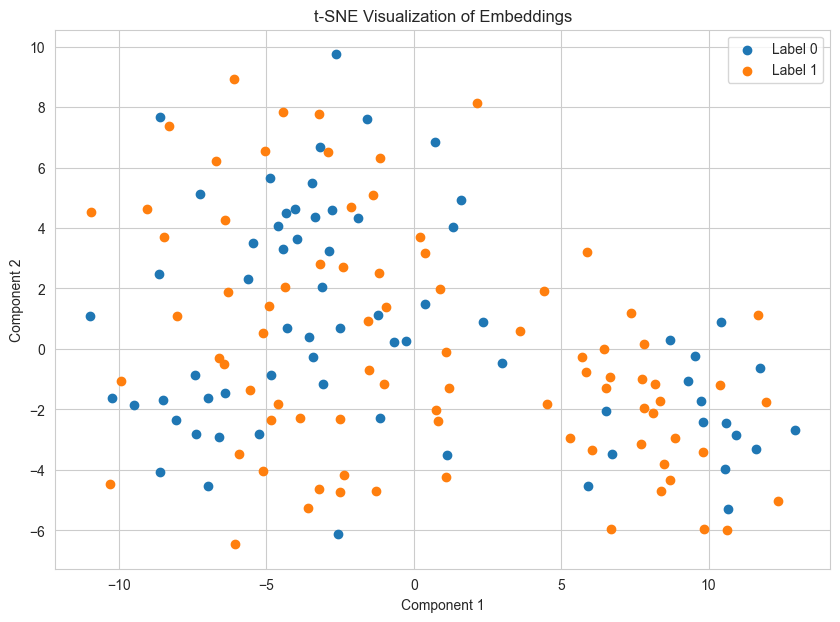

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

df_embeddings = pd.DataFrame(train_data['embedding'].tolist())
labels = train_data['label']

pca = PCA(n_components=50)
reduced_embeddings_pca = pca.fit_transform(df_embeddings)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
reduced_embeddings_tsne = tsne.fit_transform(reduced_embeddings_pca)

plt.figure(figsize=(10, 7))

for label in [0, 1]:
    indices = labels == label
    plt.scatter(reduced_embeddings_tsne[indices, 0], reduced_embeddings_tsne[indices, 1], label=f'Label {label}')

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE Visualization of Embeddings')
plt.legend()
plt.show()


## Traditional Methods

In [29]:
import pandas as pd

aug_imdb_unlabeled_path = 'imdb/aug_imdb_unlabeled.jsonl'
test_imdb_path = 'imdb/test_imdb.jsonl'
train_imdb_path = 'imdb/train_imdb.jsonl'


train_data = pd.read_json(train_imdb_path, lines=True)
test_data = pd.read_json(test_imdb_path, lines=True)
aug_data = pd.read_json(aug_imdb_unlabeled_path, lines=True)

In [30]:
import numpy as np
X_train = np.vstack(train_data['embedding'].values)
y_train = np.array(train_data['label'].values)
X_test = np.vstack(test_data['embedding'].values)
y_test = np.array(test_data['label'].values)
X_augment = np.vstack(aug_data['embedding'].values)

In this section, we utilize the K-means algorithm to cluster the augmented data and subsequently use the distances of points to propagate the labels from the training data. This process allows us to assign labels to the augmented data based on the similarity to the original training data, ensuring that the augmented data can be used effectively in our model training.

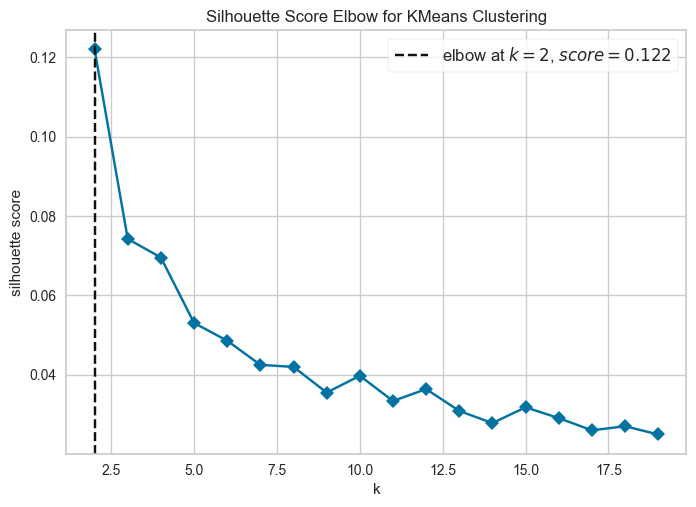

In [31]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 20), metric='silhouette', timings=False)
visualizer.fit(X_augment)
visualizer.show()
optimal_k = visualizer.elbow_value_

In [32]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(X_augment)
labels = kmeans.predict(X_augment)

propagated_labels = []
for cluster in range(optimal_k):
    cluster_center = kmeans.cluster_centers_[cluster]
    distances = np.linalg.norm(X_train - cluster_center, axis=1)
    nearest_indices = np.argsort(distances)[:7]
    nearest_labels = y_train[nearest_indices]
    majority_label = np.bincount(nearest_labels).argmax()
    propagated_labels.append(majority_label)

for i, entry in enumerate(aug_data.itertuples()):
    aug_data.at[entry.Index, 'label'] = propagated_labels[labels[i]]

combined_data = pd.concat([train_data, aug_data])
X_combined = np.vstack(combined_data['embedding'].values)
y_combined = np.array(combined_data['label'].values)

In [33]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_combined, X_test, y_combined, y_test)
models

  0%|          | 0/29 [00:00<?, ?it/s]

 97%|█████████▋| 28/29 [01:00<00:01,  1.09s/it]

[LightGBM] [Info] Number of positive: 383, number of negative: 781
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.329038 -> initscore=-0.712540
[LightGBM] [Info] Start training from score -0.712540
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [01:04<00:00,  2.23s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RidgeClassifier,0.63,0.62,0.62,0.62,0.08
RidgeClassifierCV,0.62,0.61,0.61,0.61,0.52
LinearDiscriminantAnalysis,0.61,0.61,0.61,0.60,0.52
SGDClassifier,0.61,0.60,0.60,0.59,0.09
CalibratedClassifierCV,0.61,0.60,0.60,0.58,8.33
Perceptron,0.59,0.59,0.59,0.58,0.08
LogisticRegression,0.59,0.59,0.59,0.58,0.09
PassiveAggressiveClassifier,0.59,0.58,0.58,0.57,0.14
GaussianNB,0.59,0.58,0.58,0.57,0.05


Then we use the ```LabelPropagation``` model from scikit-learn's semi-supervised learning module. This model propagates the labels from the labeled data (original training data) to the unlabeled data (augmented data). After fitting the model, we extract the labels assigned to the augmented data (X_augment). 
Similar to the previous section, we combine the original training data (X_train, y_train) with the augmented data labels obtained from label propagation (aug_labels). This creates a new dataset (X_combined, y_combined) that includes both labeled and augmented data.
We use LazyClassifier to quickly evaluate multiple classification models on the combined dataset.

In [34]:
import pandas as pd
import numpy as np
from sklearn.semi_supervised import LabelPropagation, SelfTrainingClassifier
from lazypredict.Supervised import LazyClassifier

lp_model = LabelPropagation()
lp_model.fit(np.vstack([X_train, X_augment]), np.hstack([y_train, -1 * np.ones(X_augment.shape[0])]))
aug_labels = lp_model.transduction_[-X_augment.shape[0]:]

X_combined = np.vstack([X_train, X_augment])
y_combined = np.hstack([y_train, aug_labels])

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_combined, X_test, y_combined, y_test)
models


 97%|█████████▋| 28/29 [00:53<00:01,  1.11s/it]

[LightGBM] [Info] Number of positive: 598, number of negative: 566
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513746 -> initscore=0.054997
[LightGBM] [Info] Start training from score 0.054997


100%|██████████| 29/29 [00:55<00:00,  1.93s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.78,0.78,0.78,0.78,0.67
AdaBoostClassifier,0.77,0.77,0.77,0.77,11.87
RandomForestClassifier,0.77,0.77,0.77,0.77,4.83
SVC,0.76,0.76,0.76,0.76,0.25
XGBClassifier,0.75,0.75,0.75,0.75,3.36
NuSVC,0.75,0.75,0.75,0.75,0.29
LGBMClassifier,0.74,0.74,0.74,0.74,2.27
GaussianNB,0.71,0.71,0.71,0.71,0.05
BaggingClassifier,0.70,0.70,0.70,0.70,14.19


This section demonstrates how self-training classifiers are trained and evaluated using augmented data, providing insights into the effectiveness of self-training for semi-supervised learning in this context.
A dictionary named classifiers is defined, containing various classifiers initialized with default parameters. These classifiers include Decision Tree, Logistic Regression, Gaussian Naive Bayes, Gradient Boosting, Random Forest, and different variants of Support Vector Machines (SVMs). Each classifier from the classifiers dictionary is used to create a corresponding self-training classifier.The self-training classifiers are trained using both the original training data (X_train, y_train) and the augmented data.

In [39]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import accuracy_score

classifiers = {
  "Decision Tree": DecisionTreeClassifier(),
  "Logistic Regression": LogisticRegression(max_iter=1000),
  "Gaussian Naive Bayes": GaussianNB(),
  "Random Forest": RandomForestClassifier(),
  "SVM Linear": SVC(kernel='linear', probability=True), 
  "SVM Poly": SVC(kernel='poly', probability=True), 
  "SVM rbf": SVC(kernel='rbf', probability=True), 
  "SVM sigmoid": SVC(kernel='sigmoid', probability=True), 
}

for classifier in classifiers:
    STClassifier = SelfTrainingClassifier(classifiers[classifier])
    STClassifier.fit(np.vstack([X_train, X_augment]), np.hstack([y_train, -1 * np.ones(X_augment.shape[0])]))
    y_val_pred = STClassifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_val_pred)
    print(f'{classifier} Accuracy: {accuracy:.2f}')

Decision Tree Accuracy: 0.72
Logistic Regression Accuracy: 0.82
Gaussian Naive Bayes Accuracy: 0.70
Random Forest Accuracy: 0.48
SVM Linear Accuracy: 0.76
SVM Poly Accuracy: 0.76
SVM rbf Accuracy: 0.78
SVM sigmoid Accuracy: 0.75


The ```custom_knn``` function is designed to assign a label to an unlabeled data point based on its proximity to labeled data points. It calculates distances to all labeled points, sorts them, and checks if the nearest neighbors are within a specified distance threshold. If so, it returns the most common label among the nearest neighbors; otherwise, it returns -1 to indicate uncertainty.

In [40]:
import numpy as np
import pandas as pd
from sklearn.svm import NuSVC
from sklearn.metrics import accuracy_score
from lazypredict.Supervised import LazyClassifier
import tqdm

def custom_knn(unlabeled, labeled, k, threshold, has_threshold):
    labeled['dist'] = labeled['embedding'].apply(lambda x:  (1/x.shape[0]) * (np.sum((x - unlabeled)**2)))   
    sorted_data = labeled.sort_values(by='dist')
    if has_threshold:
        if sorted_data.iloc[:k]['dist'].iloc[0] > threshold:
            return -1
    return sorted_data.iloc[:k]['label'].mode()[0]

Then we find the optimal threshold for labeling augmented data points using a custom KNN approach. This threshold is then used to create a combined dataset of original and augmented data, which is employed to train and evaluate various classifiers. The performance of these classifiers is compared to identify the best model for the given task.

In [41]:
aug_data['embedding'] = aug_data['embedding'].apply(lambda x: np.array(x))
train_data['embedding'] = train_data['embedding'].apply(lambda x: np.array(x))

X_test = np.vstack(test_data['embedding'].values)
y_test = np.array(test_data['label'].values)

thresholds = np.arange(0.0001, 0.02, 0.0005)

best_threshold = None
best_score = -np.inf
results = {}

for threshold in tqdm.tqdm(thresholds):
    aug_data['label'] = aug_data['embedding'].apply(lambda x: custom_knn(x, train_data, 7, threshold, 1))
    
    filtered_aug_data = aug_data[aug_data['label'] != -1]
    
    combined_data = pd.concat([filtered_aug_data, train_data]).reset_index(drop=True)
    
    X_combined = np.vstack(combined_data['embedding'].values)
    y_combined = np.array(combined_data['label'].values)
    
    clf = NuSVC()
    clf.fit(X_combined, y_combined)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    results[threshold] = accuracy
    
    if accuracy > best_score and len(filtered_aug_data) > 100:
        best_score = accuracy
        best_threshold = threshold

print(f"Best threshold: {best_threshold} with accuracy: {best_score}")
print("All results:", results)

aug_data['label'] = aug_data['embedding'].apply(lambda x: custom_knn(x, train_data, 7, best_threshold, 1))
filtered_aug_data = aug_data[aug_data['label'] != -1]
combined_data = pd.concat([filtered_aug_data, train_data]).reset_index(drop=True)

X_combined = np.vstack(combined_data['embedding'].values)
y_combined = np.array(combined_data['label'].values)

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_combined, X_test, y_combined, y_test)

models

100%|██████████| 40/40 [00:47<00:00,  1.20s/it]


Best threshold: 0.0126 with accuracy: 0.7666666666666667
All results: {0.0001: 0.7933333333333333, 0.0006000000000000001: 0.7933333333333333, 0.0011: 0.7933333333333333, 0.0016: 0.7933333333333333, 0.0021: 0.7933333333333333, 0.0026: 0.7933333333333333, 0.0031: 0.7933333333333333, 0.0036: 0.7933333333333333, 0.0041: 0.7933333333333333, 0.004600000000000001: 0.7933333333333333, 0.0051: 0.7933333333333333, 0.0056: 0.7933333333333333, 0.0061: 0.7933333333333333, 0.006600000000000001: 0.7933333333333333, 0.0071: 0.7933333333333333, 0.0076: 0.7933333333333333, 0.0081: 0.7933333333333333, 0.0086: 0.7933333333333333, 0.0091: 0.8, 0.0096: 0.8, 0.0101: 0.8, 0.0106: 0.7933333333333333, 0.011099999999999999: 0.7866666666666666, 0.0116: 0.8, 0.0121: 0.7733333333333333, 0.0126: 0.7666666666666667, 0.0131: 0.7533333333333333, 0.0136: 0.76, 0.0141: 0.74, 0.0146: 0.7333333333333333, 0.015099999999999999: 0.7333333333333333, 0.0156: 0.7333333333333333, 0.0161: 0.7533333333333333, 0.0166: 0.733333333333

 97%|█████████▋| 28/29 [00:07<00:00,  4.50it/s]

[LightGBM] [Info] Number of positive: 126, number of negative: 140
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68817
[LightGBM] [Info] Number of data points in the train set: 266, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473684 -> initscore=-0.105361
[LightGBM] [Info] Start training from score -0.105361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

100%|██████████| 29/29 [00:07<00:00,  3.82it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NuSVC,0.79,0.79,0.79,0.79,0.05
SVC,0.78,0.78,0.78,0.78,0.05
LogisticRegression,0.77,0.77,0.77,0.77,0.05
SGDClassifier,0.75,0.75,0.75,0.75,0.02
CalibratedClassifierCV,0.75,0.75,0.75,0.75,0.12
PassiveAggressiveClassifier,0.75,0.75,0.75,0.75,0.03
RandomForestClassifier,0.75,0.75,0.75,0.75,0.74
Perceptron,0.75,0.75,0.75,0.75,0.03
LinearSVC,0.74,0.74,0.74,0.74,0.04


Now we use custom_knn without threshold.

In [43]:
aug_data['embedding'] = aug_data['embedding'].apply(lambda x: np.array(x))
train_data['embedding'] = train_data['embedding'].apply(lambda x: np.array(x))
aug_data['label'] = aug_data['embedding'].apply(lambda x: custom_knn(x, train_data, 7, 0, 0))

combined_data = pd.concat([aug_data, train_data]).reset_index(drop=True)

X_combined = np.vstack(combined_data['embedding'].values)
y_combined = np.array(combined_data['label'].values)
X_test = np.vstack(test_data['embedding'].values)
y_test = np.array(test_data['label'].values)

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_combined, X_test, y_combined, y_test)

models

 97%|█████████▋| 28/29 [00:46<00:00,  1.04it/s]

[LightGBM] [Info] Number of positive: 550, number of negative: 614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472509 -> initscore=-0.110077
[LightGBM] [Info] Start training from score -0.110077


100%|██████████| 29/29 [00:49<00:00,  1.69s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NuSVC,0.77,0.77,0.77,0.77,0.24
SVC,0.75,0.74,0.74,0.75,0.20
RandomForestClassifier,0.74,0.74,0.74,0.74,4.60
LGBMClassifier,0.74,0.74,0.74,0.74,2.30
XGBClassifier,0.72,0.72,0.72,0.72,3.17
ExtraTreesClassifier,0.72,0.72,0.72,0.72,0.64
Perceptron,0.70,0.70,0.70,0.70,0.09
DecisionTreeClassifier,0.70,0.70,0.70,0.70,1.87
CalibratedClassifierCV,0.69,0.69,0.69,0.69,7.20


# Using LLMs

In this part we use LLMs to label our augmented data and then train our classifiers based on those labels. We use `Phi-3` as our LLMs model.

### Installing Libraries and Imports

In [ ]:
!pip install -U accelerate
!pip install -U transformers

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

### Loading Model

We will be using Phi-3 as our LLM.

In [ ]:
MODEL_ARGS = {
    'Name': 'microsoft/Phi-3-mini-128k-instruct',
    'DType': torch.bfloat16 # add torch.
}
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def load_model(model_args):


    model = AutoModelForCausalLM.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
        torch_dtype=model_args['DType'], #remove torch.
        low_cpu_mem_usage=True,
        device_map={"": device},
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
    )

    return model, tokenizer

In [ ]:
model, tokenizer = load_model(MODEL_ARGS)

### First Inference

In [ ]:
def generate_text(model, tokenizer, prompt, max_new_tokens = 100, do_sample=True, temperature=0.5):

    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    if do_sample:
        output_ids = model.generate(input_ids, max_new_tokens=max_new_tokens, do_sample=True, temperature=temperature)
    else:
        output_ids = model.generate(input_ids, max_new_tokens=max_new_tokens, do_sample=do_sample)

    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return output_text[len(prompt):]

Lets break down this function:

**Arguments**:

* **model**: The language model used for text generation.
* **tokenizer**: The tokenizer that converts text to tokens and vice versa.
* **prompt**: The initial text input that the model will build upon.
* **max_new_tokens**: The maximum number of new tokens to generate.
* **do_sample**: Whether to sample the next token or use deterministic decoding.
* **temperature**: Controls the randomness of sampling; higher values produce more diverse outputs. ( model creativity )

**Functionality**:

The `generate_text` function creates more text based on a given starting prompt using a language model and tokenizer. It first converts the prompt into tokens (numbers the model understands), then generates additional tokens to continue the text. Depending on settings, it can generate text randomly or in a fixed way. Finally, it converts the tokens back into readable text and returns the part that extends beyond the original prompt.

### Without template

We first try to give the model a prompt without a template. As you can see the model is not able to generate a satisfactory text. This is because In the name "Phi-3-mini-128k-instruct," the term "instruct" signifies that the model has been specifically fine-tuned or trained to follow instructions better than a general language model.

In [ ]:
prompt = """Tell me a funny story about a cute cat"""

generate_text(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=200,
    temperature=1.2,
)

' involved in a slapstick situation\n'

### With template

Now we try to give the model a prompt with a template. As you can see the model is able to generate a satisfactory text. This is because the model is now able to understand the template and generate text accordingly.

In [ ]:
prompt = """Insturction: Tell me a funny story about a cute cat
Answer:"""

generate_text(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=200,
    temperature=1.2,
)

" Once upon a time, there was a cute cat named Whiskers who loved to nap on the most unusual places. One sunny day while strolling around, Whiskers fell asleep on the rooftop. He snoozed on shingles and tiles all day long. When it was finally time for home, Whiskers woke up and jumped down. But unfortunately, he landed flat on his back as he forgot the law of gravity! The town gathered around laughing hilariously at the sight of the cute furball struggling to get up. From that day onwards, Whiskers was advised to keep his naps off rooftops! Despite his fall, he was still adored by everyone for his adorable innocence. Life always goes on, and people still can't help but chuckle when recalling Whiskers' grand fall."

### In Context Learning ( ICL )

LLMs can learn from their prompts, as you can give it examples or guide it and teach it how to solve the problem.

#### Learning from examples

##### No example

In [ ]:

prompt = """Question: John volunteers at a shelter once a week for 3 hours at a time. How many hours does he volunteer per year?
Answer:"""

generate_text(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=200,
    temperature=0.2,
)

' John volunteers for 192 hours per year.'

The right answer is ( 12 * 4 ) * 3 = 144

##### One Example

In [ ]:

prompt = """Question: John volunteers at a shelter once a week for 7 hours at a time. How many hours does he volunteer per year?
Answer: John volunteers 336 hours per year.
Question: John volunteers at a shelter once a week for 3 hours at a time. How many hours does he volunteer per year?
Answer:"""

generate_text(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=10,
    do_sample=False,
    temperature=0.0,
)

' John volunteers 156 hours per year'

Examples are not always effective for mathematical problems, so let's try another method.

#### Chain of Thoughts ( CoT )

In [ ]:

prompt = """Question: John volunteers at a shelter once a week for 7 hours at a time. How many hours does he volunteer per year?
Answer: There are 12 months in one year and 4 weeks in each month. So in one year, there are 12 * 4 = 48 weeks. If Jhon volunteers at a shelter once a week for 7 hours,
John volunteers 48 * 7 = 336 hours per year.
Question: John volunteers at a shelter once a week for 3 hours at a time. How many hours does he volunteer per year?
Answer:"""

generate_text(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=70,
    do_sample=False,
    temperature=0.0,
)

' There are 12 months in one year and 4 weeks in each month. So in one year, there are 12 * 4 = 48 weeks. If John volunteers at a shelter once a week for 3 hours,\nJohn volunteers 48 * 3 = 144 hours per year.'

In Chain of Thought (CoT), we guide the model with one or more examples and provide it with the steps to solve the problem.

## Labeling the Augmented Data

### First try

We give the LLM a prompt that includes two examples and instructions on how to labelize the data. We ask the LLM to return 0 if the review is negative and 1 if the review is positive. We also set the `max_new_tokens` to 1 so the LLM only returns one token.(the label) As you can see the result is good and the LLM labelize the review correctly.

In [ ]:
prompt = """Question: I will give you a movie review and you have to tell me it's positive or negative by only outputing "1" or "0": "dull, predictable and uninteresting story of a man contaminated by a chemical substance (weller) who goes on across the country just to find his ex-wife and children; meanwhile, he kills everyone in his way only by a single touch of his hands. in his dangerous track, a doctor (hurt) and a young reporter (natasha) try to stop the man. the movie has a not original premise but even though could be much better. the final result is just a movie without suspense or gritting moments. even the good cast is completely waste. i give this a 4 (four)."
            Answer:0
            Question: I will give you a movie review and you have to tell me it's positive or negative by only outputing "1" or "0": "this documentary was nominated for an oscar and it's easy to see why. even 45 years later, it is quite an impressive piece of work. why it isn't in-print is a mystery that only disney can explain. good use of live footage and animation in tandem. this used to run as part of \"vault disney\" every few months or so, but i haven't seen it listed in quite a while. *sigh* most recommended."
            Answer:1
            Question: I will give you a movie review and you have to tell me it's positive or negative by only outputing "1" or "0": "it aint bad, but it aint good. it is just entertaining.<br \/><br \/>as a comedy which it is supposed to be, it's dreadful. not many laughs at all as every joke in the movie has been done a million times before.<br \/><br \/>it's a shame as all the actors in the film are great usually, but none of them really do much. and the ending sucks."
            Answer:"""

generate_text(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=1,
    do_sample=False,
    temperature=0.0,
)

'0'

Now in order to labelize all of the data first we define a function that takes a review and returns the label.

In [ ]:
def ask_label(text, max_tokens=1):
    prompt = f"""Question: I will give you a movie review and you have to tell me it's positive or negative by only outputing "1" or "0": "dull, predictable and uninteresting story of a man contaminated by a chemical substance (weller) who goes on across the country just to find his ex-wife and children; meanwhile, he kills everyone in his way only by a single touch of his hands. in his dangerous track, a doctor (hurt) and a young reporter (natasha) try to stop the man. the movie has a not original premise but even though could be much better. the final result is just a movie without suspense or gritting moments. even the good cast is completely waste. i give this a 4 (four)."
            Answer:0
            Question: I will give you a movie review and you have to tell me it's positive or negative by only outputing "1" or "0": "this documentary was nominated for an oscar and it's easy to see why. even 45 years later, it is quite an impressive piece of work. why it isn't in-print is a mystery that only disney can explain. good use of live footage and animation in tandem. this used to run as part of \"vault disney\" every few months or so, but i haven't seen it listed in quite a while. *sigh* most recommended."
            Answer:1
            Question: I will give you a movie review and you have to tell me it's positive or negative by only outputing "1" or "0": "{text}"
            Answer:"""

    return generate_text(
        model=model,
        tokenizer=tokenizer,
        prompt=prompt,
        max_new_tokens=max_tokens,
        do_sample=False,
        temperature=0.0,
    )

Now we save all augmented reviews in a list:

In [ ]:
import json
data = []

with open("/content/aug_imdb_unlabeled.jsonl", 'r') as file:
    for line in file:
        data.append(json.loads(line)["text"])

data[:3]

['there is no relation at all between fortier and profiler but the fact that both are police series about violent crimes. profiler looks crispy, fortier looks classic. profiler plots are quite simple. fortier\'s plot are far more complicated... fortier looks more like prime suspect, if we have to spot similarities... the main character is weak and weirdo, but have "clairvoyance". people like to compare, to judge, to evaluate. how about just enjoying? funny thing too, people writing fortier looks american but, on the other hand, arguing they prefer american series (!!!). maybe it\'s the language, or the spirit, but i think this series is more english than american. by the way, the actors are really good and funny. the acting is not superficial at all...',
 "in the process of trying to establish the audiences' empathy with jake roedel (tobey maguire) the filmmakers slander the north and the jayhawkers. missouri never withdrew from the union and the union army was not an invading force. t

We also give one of the reviews to the function to make sure everything is fine: 

In [ ]:
ask_label(data[1])

'0'

Now we labelize all of the reviews and save them in `llm_aug.txt` file.

In [ ]:
import tqdm
tqdm = tqdm.tqdm
start = 0
for i in tqdm(range(start, len(data))):
    text = data[i]
    label = ask_label(text)
    with open("imdb/llm_aug.txt", 'a') as file:
        file.write(f"{i}:{label}\n")

100%|██████████| 1014/1014 [28:25<00:00,  1.68s/it]


We noticed that some the LLM responded a `\n` character to some of the reviews. We check the number of those answers and as you can see there are only few(59) of them and we can ignore and drop them.

In [ ]:
with open("imdb/llm_aug.txt", "r") as file:
    lines = file.readlines()
missed_idx = []
for line in lines:
    splitted = line.split(":")
    if (len(splitted) > 1 and splitted[1] != '\n') or splitted[0] == '\n':
        continue
    missed_idx.append(int(splitted[0]))

In [ ]:
len(missed_idx)

59

Now we set the labels to the augmented data in their dataframe:

In [9]:
import pandas as pd

with open("imdb/llm_aug.txt", "r") as file:
    lines = file.readlines()
labels = {}
for line in lines:
    splitted = line.split(":")
    if (len(splitted) > 1 and splitted[1] != '\n'):
        labels[int(splitted[0])] = int(splitted[1])

In [14]:
train_data = pd.read_json("imdb/train_imdb.jsonl", lines=True)
test_data = pd.read_json("imdb/test_imdb.jsonl", lines=True)
aug_data = pd.read_json("imdb/aug_imdb_unlabeled.jsonl", lines=True)
aug_data['label'] = aug_data.index.map(labels)
aug_data.dropna(inplace=True) #Remove rows that LLM couldn't label
aug_data['label'] = aug_data['label'].astype(int)
aug_data.head()

,text,embedding,label
0,there is no relation at all between fortier an...,"[-0.09757755700000001, -0.1536363065, 0.311417...",1
1,in the process of trying to establish the audi...,"[-0.00033669360000000004, 0.08777780830000001,...",0
2,i give this movie 7 out of 10 because the vill...,"[-0.275570631, -0.32913637160000003, 0.0793179...",1
3,this is the best sci-fi that i have seen in my...,"[0.1461943835, -0.2785910368, 0.4456491172, -0...",1
4,what an appalling piece of rubbish!!! who are ...,"[0.1696606129, 0.354041934, 0.4451519549000000...",0


Now we define our train and test data:

In [21]:
train = pd.concat([train_data[['embedding', 'label']], aug_data[['embedding', 'label']]], ignore_index=True)
test = test_data[['embedding', 'label']]
train_embeddings = pd.DataFrame(train['embedding'].tolist())
test_embeddings = pd.DataFrame(test['embedding'].tolist())

And Finally we use `lazyclassifier` to train our data on different classifiers and see which one is the best for our data.

In [22]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(train_embeddings, test_embeddings, train['label'], test['label'])

models

 97%|█████████▋| 28/29 [00:31<00:01,  1.20s/it]

[LightGBM] [Info] Number of positive: 593, number of negative: 512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 1105, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.536652 -> initscore=0.146870
[LightGBM] [Info] Start training from score 0.146870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:34<00:00,  1.18s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.88,0.88,0.88,0.88,0.23
NuSVC,0.87,0.87,0.87,0.87,0.23
RandomForestClassifier,0.83,0.83,0.83,0.83,1.77
AdaBoostClassifier,0.83,0.83,0.83,0.83,4.43
ExtraTreesClassifier,0.81,0.82,0.82,0.81,0.42
SGDClassifier,0.80,0.80,0.80,0.80,0.08
LogisticRegression,0.80,0.80,0.80,0.80,0.08
LGBMClassifier,0.80,0.80,0.80,0.80,3.20
CalibratedClassifierCV,0.79,0.79,0.79,0.79,9.92


As you can see we reach accuracy of 88% with `SVC` classifier which is much higher than the accuracy we got from in the traditional semi-supervised learning methods.

#### Another Prompt

Now this time we change our prompt and in our examples we also explain why the review is positive or negative to see if the LLM can understand the context better. We repeat the same steps as before.

In [ ]:
def ask_label_v2(text, max_tokens=1):
    prompt = f"""Question: I will give you a movie review and you have to tell me it's positive or negative by only outputing "1" or "0": "dull, predictable and uninteresting story of a man contaminated by a chemical substance (weller) who goes on across the country just to find his ex-wife and children; meanwhile, he kills everyone in his way only by a single touch of his hands. in his dangerous track, a doctor (hurt) and a young reporter (natasha) try to stop the man. the movie has a not original premise but even though could be much better. the final result is just a movie without suspense or gritting moments. even the good cast is completely waste. i give this a 4 (four)."
            Answer:0 because it used negative words like dull, predictable and uninteresting.
            Question: I will give you a movie review and you have to tell me it's positive or negative by only outputing "1" or "0": "this documentary was nominated for an oscar and it's easy to see why. even 45 years later, it is quite an impressive piece of work. why it isn't in-print is a mystery that only disney can explain. good use of live footage and animation in tandem. this used to run as part of \"vault disney\" every few months or so, but i haven't seen it listed in quite a while. *sigh* most recommended."
            Answer:1 because it used positive words like impressive, good and recommended.
            Question: I will give you a movie review and you have to tell me it's positive or negative by only outputing "1" or "0": "{text}"
            Answer:"""

    return generate_text(
        model=model,
        tokenizer=tokenizer,
        prompt=prompt,
        max_new_tokens=max_tokens,
        do_sample=False,
        temperature=0.0,
    )

In [ ]:
import tqdm
tqdm = tqdm.tqdm
start = 0
for i in tqdm(range(start, len(data))):
    text = data[i]
    label = ask_label_v2(text)
    with open("imdb/llm_aug_2.txt", 'a') as file:
        file.write(f"{i}:{label}\n")

100%|██████████| 1014/1014 [33:15<00:00,  1.97s/it]


This time we have less number of reviews that the LLM responded a `\n` character to them.

In [26]:
with open("imdb/llm_aug_2.txt", "r") as file:
    lines = file.readlines()
missed_idx = []
for line in lines:
    splitted = line.split(":")
    if (len(splitted) > 1 and splitted[1] != '\n') or splitted[0] == '\n':
        continue
    missed_idx.append(int(splitted[0]))
len(missed_idx)

47

In [31]:
import pandas as pd

with open("imdb/llm_aug_2.txt", "r") as file:
    lines = file.readlines()
labels = {}
for line in lines:
    splitted = line.split(":")
    if (len(splitted) > 1 and splitted[1] != '\n'):
        labels[int(splitted[0])] = int(splitted[1])

In [32]:
train_data = pd.read_json("imdb/train_imdb.jsonl", lines=True)
test_data = pd.read_json("imdb/test_imdb.jsonl", lines=True)
aug_data = pd.read_json("imdb/aug_imdb_unlabeled.jsonl", lines=True)
aug_data['label'] = aug_data.index.map(labels)
aug_data.dropna(inplace=True) #Remove rows that LLM couldn't label
aug_data['label'] = aug_data['label'].astype(int)
aug_data.head()

,text,embedding,label
0,there is no relation at all between fortier an...,"[-0.09757755700000001, -0.1536363065, 0.311417...",1
1,in the process of trying to establish the audi...,"[-0.00033669360000000004, 0.08777780830000001,...",0
2,i give this movie 7 out of 10 because the vill...,"[-0.275570631, -0.32913637160000003, 0.0793179...",1
3,this is the best sci-fi that i have seen in my...,"[0.1461943835, -0.2785910368, 0.4456491172, -0...",1
4,what an appalling piece of rubbish!!! who are ...,"[0.1696606129, 0.354041934, 0.4451519549000000...",0


In [33]:
train = pd.concat([train_data[['embedding', 'label']], aug_data[['embedding', 'label']]], ignore_index=True)
test = test_data[['embedding', 'label']]
train_embeddings = pd.DataFrame(train['embedding'].tolist())
test_embeddings = pd.DataFrame(test['embedding'].tolist())

Surprisingly this time we reach accuracy of 85% which is lower than the previous accuracy. This might be because the prompt was too long or too complicated.

In [34]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(train_embeddings, test_embeddings, train['label'], test['label'])

models

  0%|          | 0/29 [00:00<?, ?it/s]

 97%|█████████▋| 28/29 [00:29<00:00,  1.18it/s]

[LightGBM] [Info] Number of positive: 598, number of negative: 519
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 1117, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535363 -> initscore=0.141687
[LightGBM] [Info] Start training from score 0.141687


100%|██████████| 29/29 [00:32<00:00,  1.11s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NuSVC,0.85,0.85,0.85,0.85,0.26
SVC,0.85,0.85,0.85,0.85,0.30
LGBMClassifier,0.81,0.81,0.81,0.81,2.81
LogisticRegression,0.81,0.81,0.81,0.81,0.08
PassiveAggressiveClassifier,0.81,0.81,0.81,0.81,0.13
CalibratedClassifierCV,0.81,0.81,0.81,0.81,9.29
XGBClassifier,0.80,0.80,0.80,0.80,3.55
RidgeClassifier,0.80,0.80,0.80,0.80,0.08
ExtraTreesClassifier,0.79,0.79,0.79,0.79,0.45


In [ ]:
def ask_label_v3(text, max_tokens=1):
    prompt = f"""Question: I will give you a movie review and you have to tell me it's positive or negative or neutral by only outputing "1" or "0" or "-1": "dull, predictable and uninteresting story of a man contaminated by a chemical substance (weller) who goes on across the country just to find his ex-wife and children; meanwhile, he kills everyone in his way only by a single touch of his hands. in his dangerous track, a doctor (hurt) and a young reporter (natasha) try to stop the man. the movie has a not original premise but even though could be much better. the final result is just a movie without suspense or gritting moments. even the good cast is completely waste. i give this a 4 (four)."
Answer:0 because it used negative words like dull, predictable and uninteresting.
Question: I will give you a movie review and you have to tell me it's positive or negative by only outputing "1" or "0" or "-1": "this documentary was nominated for an oscar and it's easy to see why. even 45 years later, it is quite an impressive piece of work. why it isn't in-print is a mystery that only disney can explain. good use of live footage and animation in tandem. this used to run as part of \"vault disney\" every few months or so, but i haven't seen it listed in quite a while. *sigh* most recommended."
Answer:1 because it used positive words like impressive, good and recommended.
Question: I will give you a movie review and you have to tell me it's positive or negative by only outputing "1" or "0" or "-1": "{text}"
Answer:"""

    return generate_text(
        model=model,
        tokenizer=tokenizer,
        prompt=prompt,
        max_new_tokens=max_tokens,
        do_sample=False,
        temperature=0.0,
    )

In [ ]:
import tqdm
tqdm = tqdm.tqdm
start = 0
for i in tqdm(range(start, len(data))):
    text = data[i]
    label = ask_label_v3(text)
    with open("labels.txt", 'a') as file:
        file.write(f"{i}:{label}\n")

100%|██████████| 1014/1014 [31:20<00:00,  1.85s/it]


### LLM as a Classifier!

We also check what happens if we use the LLM as a classifier and forget about augmented data. We give the LLM the reviews of the test data and ask it to labelize them. We also use the first prompt that we used to labelize the augmented data.

In [ ]:
import json
data_test = []

with open("/content/test_imdb.jsonl", 'r') as file:
    for line in file:
        data_test.append(json.loads(line)["text"])

data_test[:3]

["the 60s (1999) d: mark piznarski. josh hamilton, julia stiles, jerry o'connell, jeremy sisto, jordana brewster, leonard roberts, bill smitrovich, annie corley, charles s. dutton. nbc mini-series (later released to video/dvd as full length feature film) about the treacherous 1960s, as seen through the eyes of both a white family and a black family. the film's first half is driven by the excellent performance of dutton as reverend willie taylor and evenly spreads the storyline between the families. however, dutton's character is killed halfway through and the black family is completely forgotten in a dull, incoherent, and downright awful 2nd half. rating: 4 out of 10. not rated (later rated pg-13 for video/dvd release).",
 "hello. this movie is.......well.......okay. just kidding! its awesome! it's not a block buster smash hit. it's not meant to be. but its a big hit in my world. and my sisters. we are rockin' rollers. go ramones!!!! this is a great movie.............. for me!",
 "eyel

In [ ]:
import tqdm
tqdm = tqdm.tqdm
start = 0
for i in tqdm(range(start, len(data_test))):
    text = data_test[i]
    label = ask_label(text)
    with open("labels_test.txt", 'a') as file:
        file.write(f"{i}:{label}\n")

100%|██████████| 150/150 [04:12<00:00,  1.68s/it]


In [37]:
with open("imdb\llm_test_labels.txt", "r") as file:
    lines = file.readlines()
labels = {}
for line in lines:
    splitted = line.split(":")
    if (len(splitted) > 1 and splitted[1] != '\n'):
        labels[int(splitted[0])] = int(splitted[1])

As you can see the LLM accuracy is 96% which is much higher than the accuracy we got from in the previous parts!

In [38]:
from sklearn.metrics import accuracy_score

accuracy_score(list(labels.values()), test['label'])

0.9666666666666667

# Questions

1. #### **Research semi-supervised problems and explain how to select a proportion of data for manual labeling. Does the choice of data matter?**

To select a proportion of data for manual labeling, begin with a random sample to get an initial labeled dataset. This helps in training a preliminary model .Then, we use active learning strategies to iteratively select and label the most informative samples. Techniques like uncertainty sampling, query-by-committee, or expected model change can be effective. we should use the model’s confidence scores to identify uncertain samples. Focus on labeling those samples to enhance the model’s decision boundary. at the end, continuously evaluate the model's performance and iteratively refine the labeled dataset by adding more informative samples.

The choice of data for manual labeling significantly impacts the effectiveness of semi-supervised learning. 
- Ensure the manually labeled data is representative of the entire dataset. This helps the model generalize better.
- Samples near the decision boundary (where the model is less confident) are often the most informative for labeling. Active learning can identify these samples, improving the model's ability to distinguish between classes.
- Label a diverse set of samples to cover different aspects of the data distribution. This prevents the model from overfitting to a particular subset of the data.
- Use model uncertainty to guide labeling. Samples that the model is uncertain about (low confidence in predictions) are typically more valuable for improving the model's performance.



2. #### **For label propagation, how many data points did you label using your manually labeled data? Explain the trade-off between quality and quantity of your labeled data.**

We have experimented with two different approaches for label propagation:

- Without Thresholds:

   Initially, we labeled all augmented data points without applying any threshold on the distance or the number of labeled data points.
   This approach maximized the quantity of labeled data but potentially compromised the quality, as all points, regardless of their similarity to the manually labeled data, were labeled.
- With Thresholds:

   We then introduced thresholds on the maximum distance of the nearest points to control the labeling process.
   A distance threshold ensures that only points within a certain similarity range to the manually labeled points are considered for labeling.
   An additional threshold on the number of labeled data points ensures that there are enough augmented points to train the model effectively.
   This approach aims to balance quality and quantity by filtering out less similar points, thus improving the overall accuracy and reliability of the labels.
   The best threshold was selected based on the accuracy of the model on the test set, ensuring that the trade-off between the quality and quantity of labeled data was optimized for the best performance.

In the code above, the number of data points labeled using the manually labeled data can be inferred from the filtered_aug_data DataFrame. This DataFrame contains the augmented data points that were successfully labeled using the custom_knn function based on the embeddings in train_data.

Trade-off Between Quality and Quantity of Labeled Data
- Quality of Labeled Data:

   - Higher Quality:

      Using a lower threshold ensures that only the points that are very similar to the manually labeled data (within a smaller distance) are labeled, increasing the accuracy and reliability of the labels.
      However, setting the threshold too low might result in very few points being labeled, reducing the overall benefit of label propagation.
   - Lower Quality:

      Using a higher threshold allows more points to be labeled, but at the risk of including less accurate labels. This could introduce noise and reduce the overall model performance.
      If the distance threshold is too high, points that are not very similar to any manually labeled points might be incorrectly labeled.
- Quantity of Labeled Data:

   - Higher Quantity:
      Increasing the number of labeled points (by using a higher threshold) provides more data for training, which can improve the model’s performance, provided the labels are reasonably accurate.
      The condition len(filtered_aug_data) > 100 ensures that enough augmented points are available to meaningfully enhance the dataset.

   - Lower Quantity:
      A smaller number of high-quality labeled points might not be sufficient to capture the complexity of the data distribution, limiting the model's performance.







3. #### **Research the limitations of label propagation methods. Can these limitations be overcome using a large language model (LLM)? If yes, explain how and why using LLMs is more effective for these tasks.**

    The limitation of label propagation methods are:

    * **Scalability**: For large datasets, label propagation can be computationally expensive and may not scale well as it needs to compute the pairwise similarity between all data points.

    * **Quality of Graph**: The performance of label propagation is highly dependent on the quality of the graph constructed from the data. If the graph does not capture the underlying structure of the data well and the similarity measure used is not appropriate, the label propagation results may be suboptimal.

    * **Initialization Sensitivity**: The initial labels provided to the algorithm can significantly impact the final labeling of the data points. If the initial labels are incorrect or biased, the propagation process may propagate these errors throughout the dataset.

    * **Convergence Issues**: Label propagation may not always converge to a stable solution or may get stuck in local optima, leading to suboptimal labeling of the data points.

    When using LLMs we won't have issues like Quality of Graph or Initialization Sensitivity or Convergence Issues because LLMs don't need much data to be able to labelize the data(As we saw in our task we only gave it 2 examples and it was able to labelize the data very accurately) but we still have the issue of Scalability. We can use LLMs when it doesn't take too much time and resources to labelize the data. Also we should be aware that LLMs are good in general subjects but they might not be good in technical subjects like medical or legal subjects.

4. #### **Research the history of language modeling, their evolution, and explain how they work. Discuss the advantages and limitations of language models, especially large language models (LLMs), in various tasks.** 

   Language modeling has a rich history that spans several decades, evolving through various stages of development:

   1. **Early Statistical Models**:
      - **N-grams**: One of the earliest forms of language models, where the probability of a word is conditioned on a fixed number of preceding words. For example, a bigram model considers the probability of a word given the previous word.
      - **Hidden Markov Models (HMMs)**: Used extensively in the 1980s and 1990s, HMMs model the sequence of words as a probabilistic process with hidden states.

   2. **Neural Network-Based Models**:
      - **Feedforward Neural Networks**: In the early 2000s, models like the Neural Probabilistic Language Model (NPLM) used feedforward neural networks to predict the next word in a sequence, capturing more complex patterns than n-gram models.
      - **Recurrent Neural Networks (RNNs)**: Introduced in the 1990s but became prominent in the 2010s, RNNs, and their variants like Long Short-Term Memory (LSTM) and Gated Recurrent Units (GRUs), are capable of capturing dependencies across longer sequences.

   3. **Transformers and Attention Mechanisms**:
      - **Attention Mechanisms**: Proposed in 2014, attention mechanisms allow models to focus on specific parts of the input sequence, improving performance in tasks like translation.
      - **Transformer Models**: Introduced by Vaswani et al. in 2017, the Transformer model uses self-attention mechanisms to process entire sequences simultaneously, rather than sequentially like RNNs. This architecture became the foundation for modern language models.

   4. **Large Pre-trained Models**:
      - **BERT (Bidirectional Encoder Representations from Transformers)**: Introduced by Google in 2018, BERT uses a bidirectional approach to pre-train transformers, capturing context from both directions in a text sequence.
      - **GPT (Generative Pre-trained Transformer)**: Developed by OpenAI, GPT models use a unidirectional approach, focusing on generating text. GPT-2 (2019) and GPT-3 (2020) marked significant advances, with GPT-3 being a particularly large model with 175 billion parameters.
      - **T5 (Text-To-Text Transfer Transformer)**: Introduced by Google in 2019, T5 frames all NLP tasks as text-to-text tasks, leveraging a unified approach for various applications.



   Language models predict the probability of a sequence of words. They can be used for various tasks, including text generation, translation, and classification. Here's a general overview of how they function:

   1. **Training**:
      - **Data Collection**: Large corpora of text are collected for training.
      - **Tokenization**: Text is split into smaller units (tokens), such as words or subwords.
      - **Model Architecture**: Depending on the architecture (e.g., RNN, Transformer), the model learns to predict the next token in a sequence or to understand the context of tokens.

   2. **Inference**:
      - **Contextual Understanding**: The model uses the context provided by preceding tokens to predict the next token or to understand the input sequence.
      - **Probability Distribution**: The model generates a probability distribution over the vocabulary for the next token, choosing the token with the highest probability.

   Advantages:

   * **Versatility**: Language models can be applied to a wide range of tasks, from text generation and summarization to translation and sentiment analysis.

    * **Contextual Understanding**: Large models like BERT and GPT-3 can understand and generate coherent and contextually relevant text, making them useful in various applications.
    
    * **Transfer Learning**: Pre-trained models can be fine-tuned on specific tasks with relatively small amounts of data, leveraging the knowledge acquired during pre-training.

    * **Improved Performance**: Large language models have achieved state-of-the-art performance in many NLP benchmarks, demonstrating their ability to capture complex patterns in language.
    
    Limitations:

    * **Resource Intensive**: Training and deploying large language models require significant computational resources and memory, making them expensive to develop and maintain.
    
    * **Bias and Fairness**: Language models can inherit and amplify biases present in the training data, leading to biased or unfair outputs.
    
    * **Interpretability**: Understanding why a language model generates a specific output can be challenging, making it difficult to debug and trust the model’s decisions.
    
    * **Data Dependency**: The quality of the model’s output heavily depends on the quality and diversity of the training data. Poorly curated datasets can lead to suboptimal performance.
    
    * **Context Limitations**: Despite their capabilities, language models can struggle with maintaining context over very long sequences, sometimes producing incoherent or irrelevant responses.

5. #### **For each method (LLM/Label-Propagation), explain its advantages and disadvantages.**
   LLMs:
      * Advantages:
         * **Contextual Understanding**: LLMs can generate text that is contextually relevant and coherent, making them suitable for various NLP tasks.
         * **Transfer Learning**: Pre-trained LLMs can be fine-tuned on specific tasks with minimal data, leveraging the knowledge acquired during pre-training.
         * **Versatility**: LLMs can be applied to a wide range of tasks, from text generation to classification and translation.
      * Disadvantages:
         * **Resource Intensive**: Training and deploying large language models require significant computational resources and memory, making them expensive to develop and maintain.
         * **prompt sensitivity**: LLMs can be sensitive to the quality and structure of the prompts provided, affecting the quality of the generated text.
         * **Time Consuming**: LLMs can be slow in generating text, especially for large models like GPT-3, which can impact real-time applications.
   Label Propagation:
      * Advantages:
         * **Less time and resource consuming**: Label propagation methods are generally faster and less resource-intensive compared to training large language models.
         * **Better on more technical subjects**: Label propagation methods can be more effective in domains where it's much more technical than common knowledge.
      * Disadvantages:
         * **Quality of Graph**: The performance of label propagation is highly dependent on the quality of the graph constructed from the data. If the graph does not capture the underlying structure of the data well and the similarity measure used is not appropriate, the label propagation results may be suboptimal.

         * **Initialization Sensitivity**: The initial labels provided to the algorithm can significantly impact the final labeling of the data points. If the initial labels are incorrect or biased, the propagation process may propagate these errors throughout the dataset.

6. #### **Certainly, you have worked with large language models (LLMs) since they were made public, and you might even be using one right now to help you with your assignment! How has your experience been while interacting with one of them? How do other LLMs differ from each other? Name some of these LLMs that you have worked with and share your opinion about them.**
   Most of the LLMs that I have worked with so far are ChatGPT style and they seem to be more user-friendly and less prompt-sensitive than the one we worked with in this assignment however models like ChatGPT will also have different efficiency when we give them a better prompt. 

   Differences between LLMs:
      * **Size and Parameters**: The number of parameters in an LLM is often linked to its complexity and capabilities. Larger models generally require more computational resources and can be more expensive to run. However, they might also offer better performance in areas like factual language understanding or creative text generation. For example `phi-3` is much simpler than models like `Gemeni` or `GPT-4`

      * **Focus and Specialization**: Some LLMs are designed for general-purpose tasks, while others are specialized for specific domains like question answering, code generation, or machine translation. This specialization often involves fine-tuning the model on relevant datasets or tasks. For example Github Copilot is an LLM that is designed for coding purposes only.

      * **Open-Source vs. Closed-Source**:  Some LLMs are open-source, meaning their code is publicly available for anyone to inspect, modify, and use. Others are closed-source, with access and usage controlled by the developers. Open-source models offer transparency and potential for community contributions, while closed-source models might offer better performance or proprietary features. For example LLMs like `phi-3` that we worked with in this assignment or Meta's `llama` are open source and on the other hand OpenAI's LLMs are ironically closed source :)
      
      * **Modality**: some LLMs are starting to explore processing information beyond just text. These multimodal models might be trained on datasets that include images, code, or audio, allowing them to understand and generate more complex outputs.



   









